In [1]:
import sqlite3
import pandas as pd

# Conectar a la base de datos SQLite
conexion = sqlite3.connect("C:\\Users\\andre\\Documents\\GitHub\\nba-data-analytics\\NBA_DATA.db")

# Leer todos los registros de la tabla GAMES
query = """
SELECT 
    gs.*,
    g.GAME_DATE,
    g.SEASON,
    g.H_TEAM_ID,
    g.A_TEAM_ID,
    ods.Average_H,
    ods.Average_A
FROM GAME_STATS gs
LEFT JOIN GAMES g ON gs.GAME_ID = g.GAME_ID
LEFT JOIN GAME_ODS ods ON gs.GAME_ID = ods.GAME_ID
"""
games_df = pd.read_sql_query(query, conexion)

# # Cerrar la conexión
conexion.close()

In [2]:
# Separa locales y visitantes
home_df = games_df[games_df['HOME_FLAG'] == 1].copy()
away_df = games_df[games_df['HOME_FLAG'] == 0].copy()

# Renombra columnas para distinguir
home_df = home_df.add_prefix('HOME_')
away_df = away_df.add_prefix('AWAY_')

# Ajusta los nombres de las columnas clave para el merge
home_df = home_df.rename(columns={'HOME_GAME_ID': 'GAME_ID', 'HOME_SEASON': 'SEASON'})
away_df = away_df.rename(columns={'AWAY_GAME_ID': 'GAME_ID', 'AWAY_SEASON': 'SEASON'})

# Haz el merge
merged = pd.merge(home_df, away_df, on=['GAME_ID', 'SEASON'], suffixes=('_HOME', '_AWAY'))

merged.drop(['HOME_HOME_FLAG', 'HOME_AWAY_FLAG', 'HOME_CITY', 'HOME_NICKNAME',
             'AWAY_HOME_FLAG', 'AWAY_AWAY_FLAG', 'AWAY_CITY', 'AWAY_NICKNAME'
             ], axis=1, inplace=True)

In [3]:
def add_dynamic_rankings(df):
    df = df.copy()
    # Ordena por temporada y fecha de partido
    df = df.sort_values(['SEASON', 'HOME_GAME_DATE'])
    # Calcula victorias acumuladas para cada equipo local y visitante
    df['HOME_WINS_CUM'] = df.groupby(['SEASON', 'HOME_TEAM_ID'])['HOME_W'].cumsum()
    df['AWAY_WINS_CUM'] = df.groupby(['SEASON', 'AWAY_TEAM_ID'])['AWAY_W'].cumsum()

    df['HOME_GAMES_PLAYED'] = df.groupby(['SEASON', 'HOME_TEAM_ID']).cumcount() + 1
    df['AWAY_GAMES_PLAYED'] = df.groupby(['SEASON', 'AWAY_TEAM_ID']).cumcount() + 1
    
    # Función para calcular ranking tras cada partido
    def get_ranks(subdf):
        home_ranks = []
        away_ranks = []
        # Para cada partido en la temporada
        for idx, row in subdf.iterrows():
            # Ranking local
            home_table = subdf.loc[:idx].groupby('HOME_TEAM_ID')['HOME_WINS_CUM'].max()
            home_rank = home_table.rank(ascending=False, method='min')[row['HOME_TEAM_ID']]
            home_ranks.append(int(home_rank))
            # Ranking visitante
            away_table = subdf.loc[:idx].groupby('AWAY_TEAM_ID')['AWAY_WINS_CUM'].max()
            away_rank = away_table.rank(ascending=False, method='min')[row['AWAY_TEAM_ID']]
            away_ranks.append(int(away_rank))
        return pd.DataFrame({'HOME_RANK': home_ranks, 'AWAY_RANK': away_ranks}, index=subdf.index)
    
    # Aplica por temporada
    rankings = df.groupby('SEASON', group_keys=False).apply(get_ranks)
    df = pd.concat([df, rankings], axis=1)
    return df

# Uso:
merged = add_dynamic_rankings(merged)[['GAME_ID', 'SEASON', 'HOME_TEAM_ID', 'AWAY_TEAM_ID', 'HOME_RANK', 'AWAY_RANK', 'HOME_W', 'AWAY_W', 'HOME_Average_H', 'HOME_Average_A', 'HOME_GAME_DATE', 'HOME_GAMES_PLAYED', 'AWAY_GAMES_PLAYED']].dropna()
merged[['HOME_W','AWAY_W']] = merged[['HOME_W','AWAY_W']].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
merged = merged.loc[(merged['HOME_GAMES_PLAYED'] + merged['AWAY_GAMES_PLAYED']) > 7]


C:\Users\andre\AppData\Local\Temp\ipykernel_368\1708830127.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rankings = df.groupby('SEASON', group_keys=False).apply(get_ranks)


In [ ]:
x = 5
y = 25
stage = 1
predictions = []
results = []
for index, row in merged.iterrows():
    if row['HOME_RANK'] <= x:
        if row['AWAY_RANK'] <= x:
            prediction = -1
        else:
            prediction = 1
    elif row['HOME_RANK'] >= y:
        if row['AWAY_RANK'] >= y:
            prediction = -1
        else:
            prediction = 0
    elif row['AWAY_RANK'] <= x:
        prediction = 0
    elif row['AWAY_RANK'] >= y:
        prediction = 1
    else:
        prediction = -1
    predictions.append(prediction)

    if prediction == -1:
        result = 0
    elif prediction == 0:
        if row['HOME_W'] == 0:
            result = row['HOME_Average_A'] * stage
        else:
            result = -1
    elif prediction == 1:
        if row['HOME_W'] == 1:
            result = row['HOME_Average_H'] * stage
        else:
            result = -1
    results.append(result)
merged['PREDICTION'] = predictions
merged['result'] = results

print(f"Ganancia con apuestas de {stage}: {sum(results)}")
print(f"Número de apuestas realizadas: {len([r for r in results if r != 0])}")
print(f"Tasa de acierto: {len([r for r in results if r > 0]) / len([r for r in results if r != 0]) * 100:.2f}%")
print(f"Retorno sobre la inversión (ROI): {sum([r for r in results if r != 0]) / (len([r for r in results if r != 0])) * stage * 100:.2f}%")

Ganancia con apuestas de 1: 3692.669999999993
Número de apuestas realizadas: 3889
Tasa de acierto: 75.88%
Retorno sobre la inversión (ROI): 94.95%


In [9]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as mdates
def calcular_estadisticas(df):
    total_bets = len(df)
    if total_bets == 0:
        return {"Error": "El DataFrame está vacío."}

    df['profit'] = np.where(
        df['result'] == 1,
        df['odds'] * df['stake'] - df['stake'],
        -df['stake']
    )

    # Calcular equity acumulado
    df['equity'] = df['profit'].cumsum()

    # Calcular drawdown absoluto y relativo (%)
    df['peak'] = df['equity'].cummax()
    df['drawdown'] = df['equity'] - df['peak']
    df['drawdown_pct'] = df['drawdown'] / df['peak'].replace(0, np.nan)  # evitar división por cero

    max_drawdown_pct = df['drawdown_pct'].min() * 100  # en porcentaje

    # Estadísticas básicas
    wins = df[df['result'] == 1]
    roi = df['profit'].sum() / df['stake'].sum()
    yield_ = df['profit'].sum() / total_bets
    winrate = len(wins) / total_bets
    total_profit = df['profit'].sum()  # 💰 profit total

    return {
        "Total Bets": total_bets,
        "ROI": round(roi, 4),
        "Yield": round(yield_, 2),
        "Winrate": round(winrate * 100, 2),
        "Total Profit": round(total_profit, 2),        # 👈 añadido
        "Max Drawdown (%)": round(max_drawdown_pct, 2)
    }

def return_grafic(df):
    df = df.copy()
    df['profit'] = np.where(df['result'] == 1, df['odds'] * df['stake'] - df['stake'], -df['stake'])
    df['accumulated'] = df['profit'].cumsum()

    # Asegurar tipo datetime
    df['date'] = pd.to_datetime(df['date'])

    # Ordenar por fecha
    df = df.sort_values('date')

    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['accumulated'], marker='o', linestyle='-')

    # Formateo de fechas
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')

    plt.title("Cumulative gain over time")
    plt.xlabel("Date")
    plt.ylabel("Cumulative gain")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
def prepare_betting_analysis(merged, x, y, mode=0, min_stake=1, max_stake=10):
    df = merged.copy()  # no modifica el original
    predictions = []
    results = []
    odds = []
    diference = []
    stakes = 100

    for index, row in df.iterrows():
        if row['HOME_RANK'] <= x and mode in [0,1]:
            if row['AWAY_RANK'] <= x:
                prediction = -1
                diference.append(-1)
            else:
                prediction = 1
                diference.append(row['AWAY_RANK'] - row['HOME_RANK'])
        elif row['HOME_RANK'] >= y and mode in [0,-1]:
            if row['AWAY_RANK'] >= y:
                prediction = -1
                diference.append(-1)
            else:
                prediction = 0
                diference.append(row['HOME_RANK'] - row['AWAY_RANK'])
        elif row['AWAY_RANK'] <= x and mode in [0,1]:
            prediction = 0
            diference.append(row['HOME_RANK'] - row['AWAY_RANK'])
        elif row['AWAY_RANK'] >= y and mode in [0,-1]:
            prediction = 1
            diference.append(row['AWAY_RANK'] - row['HOME_RANK'])
        else:
            prediction = -1
            diference.append(-1)
        predictions.append(prediction)

        if prediction == -1:
            result = -1
            odds.append(0)
        elif prediction == 0:
            if row['HOME_W'] == 0:
                result = 1
                odds.append(row.get('HOME_Average_A', 0))
            else:
                result = 0
                odds.append(row.get('HOME_Average_A', 0))
        elif prediction == 1:
            if row['HOME_W'] == 1:
                result = 1
                odds.append(row.get('HOME_Average_H', 0))
            else:
                result = 0
                odds.append(row.get('HOME_Average_H', 0))
        results.append(result)

    # Asignar columnas usando Series con el mismo índice para no desajustar
    df['PREDICTION'] = pd.Series(predictions, index=df.index)
    df['result'] = pd.Series(results, index=df.index)
    df['odds'] = pd.Series(odds, index=df.index).astype(float)
    df['diference'] = pd.Series(diference, index=df.index)
    df['date'] = df['HOME_GAME_DATE']

    valid_diffs = df.loc[df['diference'] > -1, 'diference']
    if not valid_diffs.empty:
        min_diff, max_diff = valid_diffs.min(), valid_diffs.max()
        if min_diff == max_diff:
            df['stake'] = max_stake
        else:
            df['stake'] = df['diference'].apply(
                lambda d: min_stake if d == -1 else 
                max_stake - (max_stake - min_stake) * (d - min_diff) / (max_diff - min_diff)
            )
    else:
        df['stake'] = min_stake

    return df

    return df

In [12]:
xs = range(0, 31)
ys = range(0, 31)

roi_matrix = pd.DataFrame(index=xs, columns=ys, dtype=float)
winrate_matrix = pd.DataFrame(index=xs, columns=ys, dtype=float)
totalbets_matrix = pd.DataFrame(index=xs, columns=ys, dtype=float)

for x in xs:
    for y in ys:
        # df_test = prepare_betting_analysis(merged, x, y, mode=-1)   # trabaja sobre copia internamente
        df_test1 = prepare_betting_analysis(merged, x, y, mode=1)
        df_test2 = prepare_betting_analysis(merged, x, y, mode=-1)
        df_combined = pd.concat([df_test1, df_test2], ignore_index=True, sort=False)
        df_test = df_combined.sort_values('date', ascending=True).reset_index(drop=True)
        bets = df_test.loc[df_test['result'] != -1].copy()  # solo filas con apuesta
        if len(bets) == 0:
            roi = np.nan
            winrate = np.nan
            total = 0
        else:
            stats = calcular_estadisticas(bets)
            roi = stats.get('ROI', np.nan)
            winrate = stats.get('Winrate', np.nan)
            total = stats.get('Total Bets', len(bets))
        roi_matrix.at[x, y] = roi
        winrate_matrix.at[x, y] = winrate
        totalbets_matrix.at[x, y] = total

# Imprimir matrices (filas = x, columnas = y)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("ROI matrix (rows=x, cols=y):")
print(roi_matrix)
print("\nWinrate matrix (percent):")
print(winrate_matrix)
print("\nTotal bets matrix:")
print(totalbets_matrix)

# Opcional: guardar a csv
roi_matrix.to_csv("roi_matrix_x0_30_y0_30.csv")
winrate_matrix.to_csv("winrate_matrix_x0_30_y0_30.csv")
totalbets_matrix.to_csv("totalbets_matrix_x0_30_y0_30.csv")
# ...existing code...

ROI matrix (rows=x, cols=y):
        0       1       2       3       4       5       6       7       8   \
0      NaN     NaN  0.1862  0.2089  0.2032  0.2083  0.1838  0.1911  0.1870   
1   0.1862  0.1862  0.1862  0.2000  0.1977  0.2021  0.1844  0.1899  0.1868   
2   0.2089  0.2089  0.2000  0.2089  0.2056  0.2085  0.1928  0.1973  0.1943   
3   0.2032  0.2032  0.1977  0.2056  0.2032  0.2060  0.1921  0.1961  0.1935   
4   0.2083  0.2083  0.2021  0.2085  0.2060  0.2083  0.1955  0.1991  0.1967   
5   0.1838  0.1838  0.1844  0.1928  0.1921  0.1955  0.1838  0.1875  0.1855   
6   0.1911  0.1911  0.1899  0.1973  0.1961  0.1991  0.1875  0.1911  0.1890   
7   0.1870  0.1870  0.1868  0.1943  0.1935  0.1967  0.1855  0.1890  0.1870   
8   0.1871  0.1871  0.1869  0.1942  0.1934  0.1965  0.1856  0.1890  0.1871   
9   0.1810  0.1810  0.1822  0.1899  0.1895  0.1929  0.1823  0.1857  0.1839   
10  0.1699  0.1699  0.1737  0.1823  0.1826  0.1866  0.1762  0.1798  0.1781   
11  0.1695  0.1695  0.1734  0.1820 

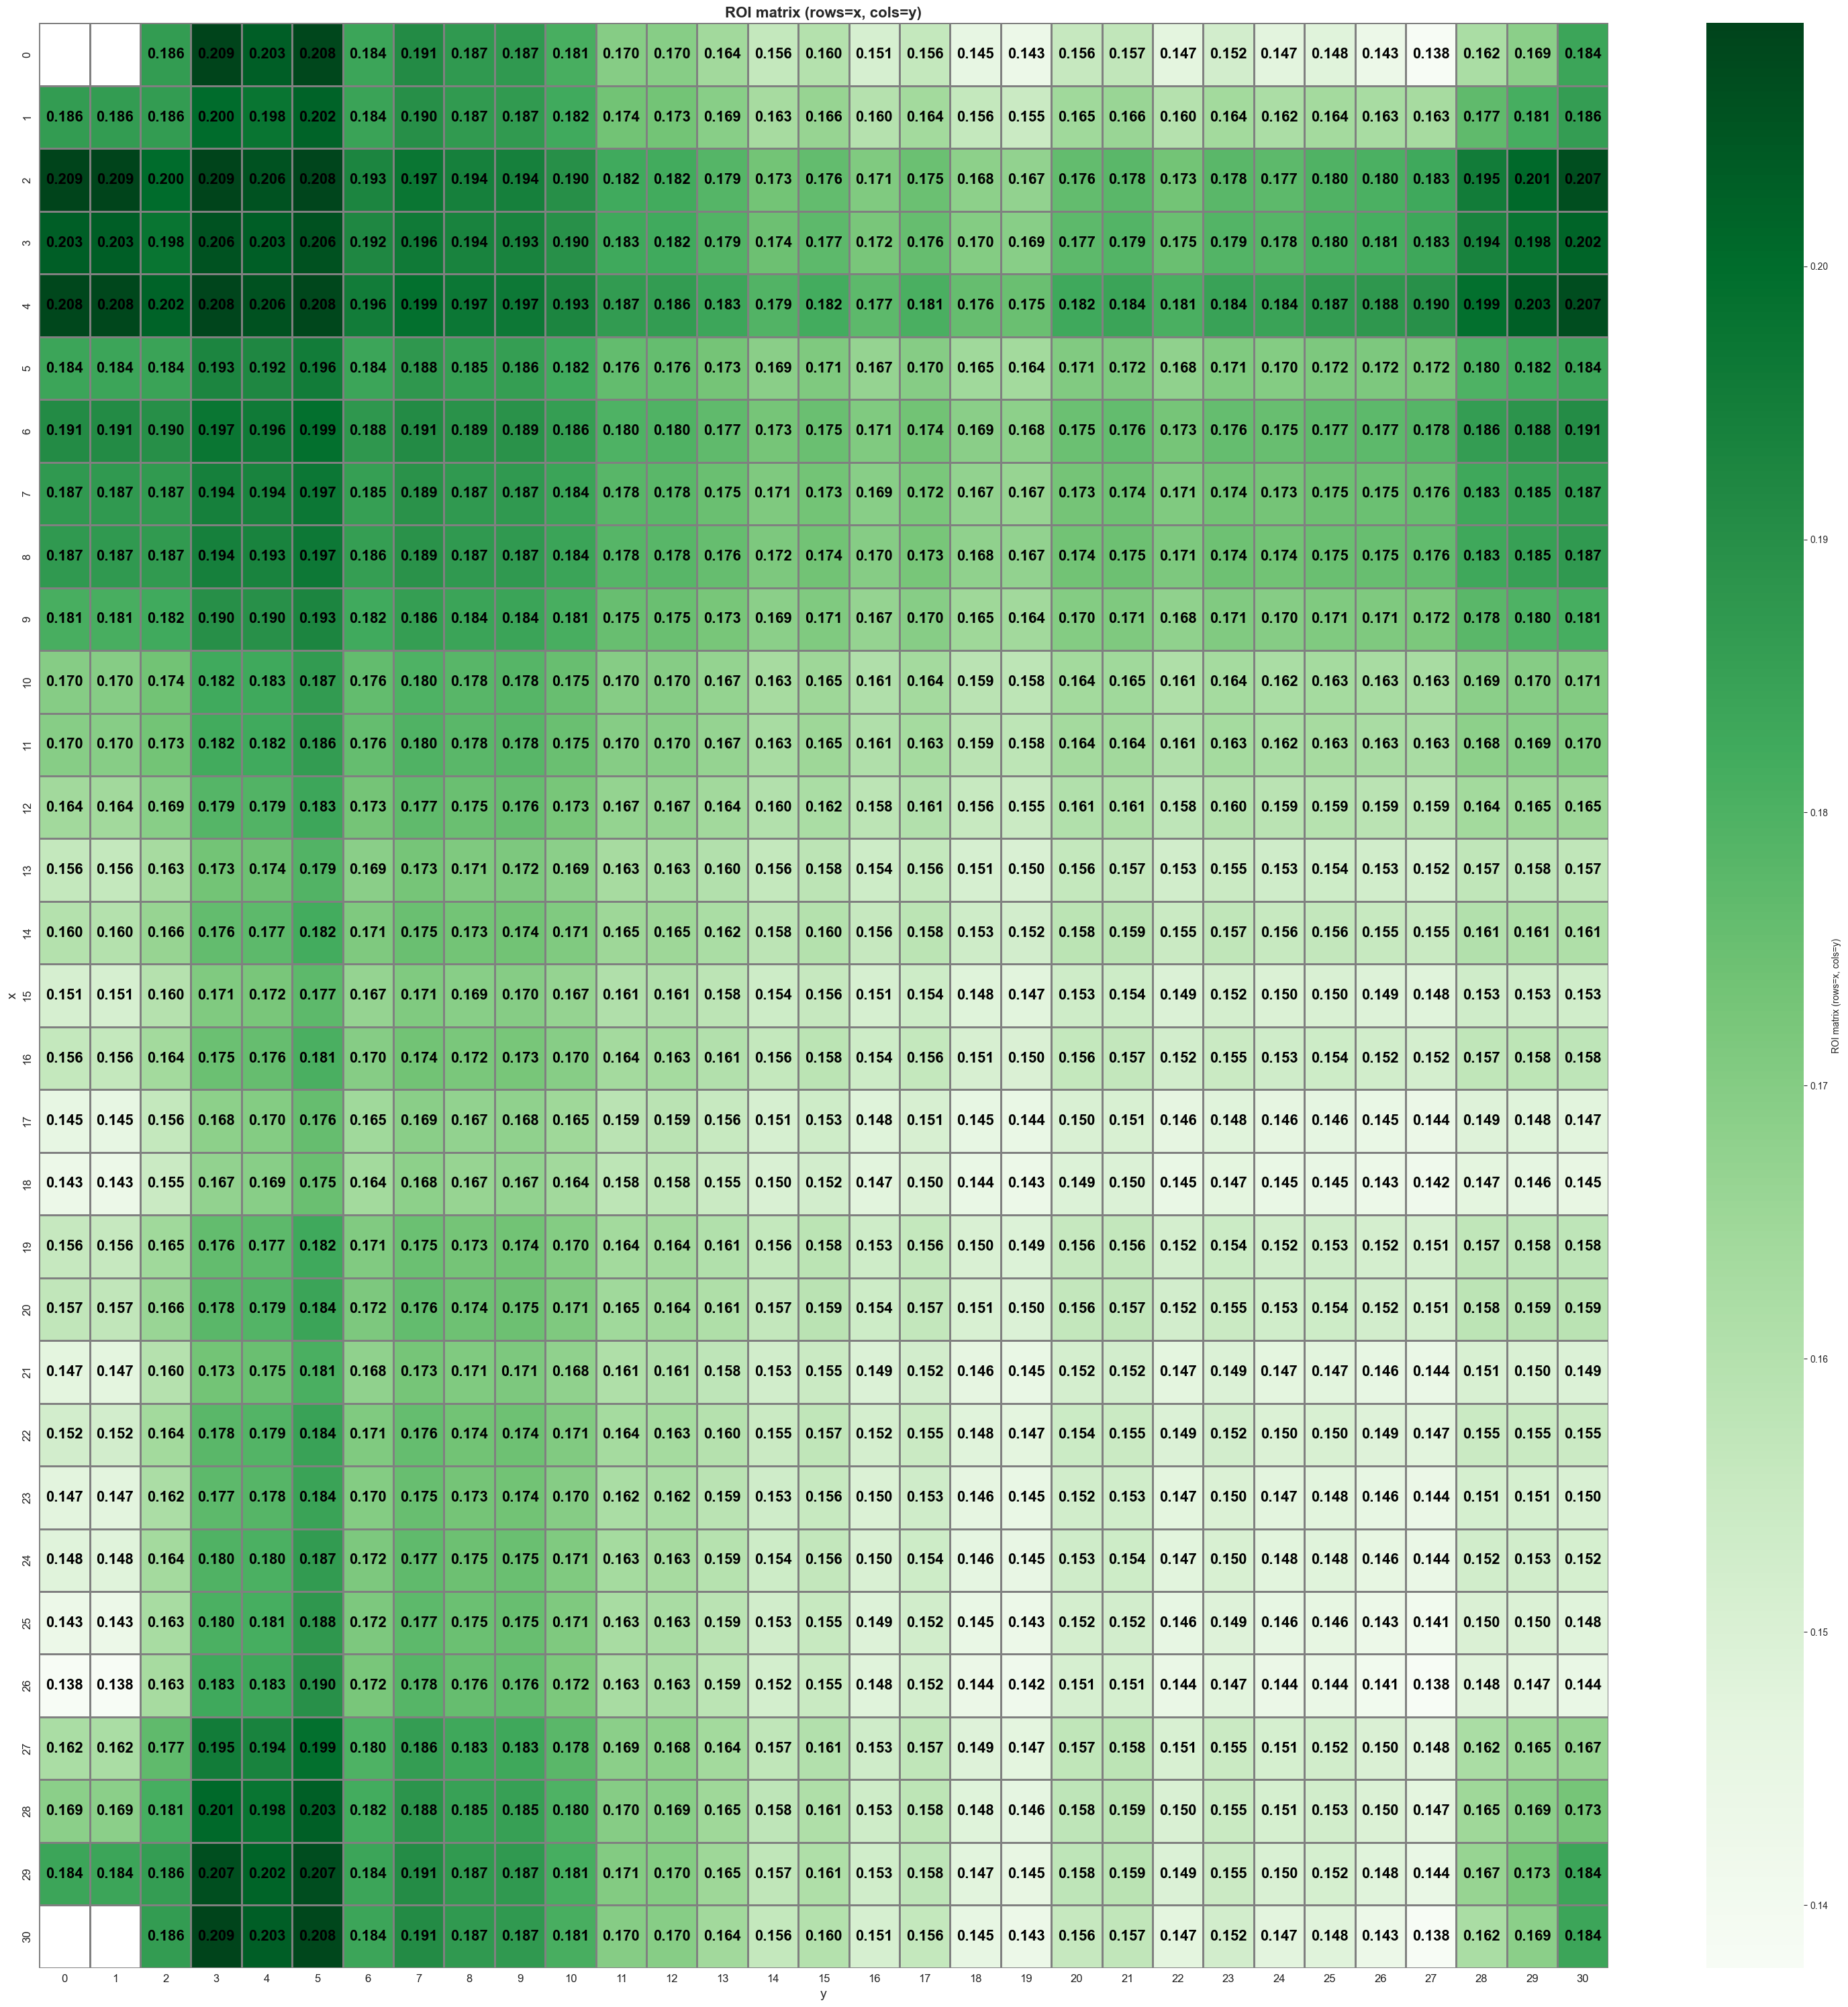

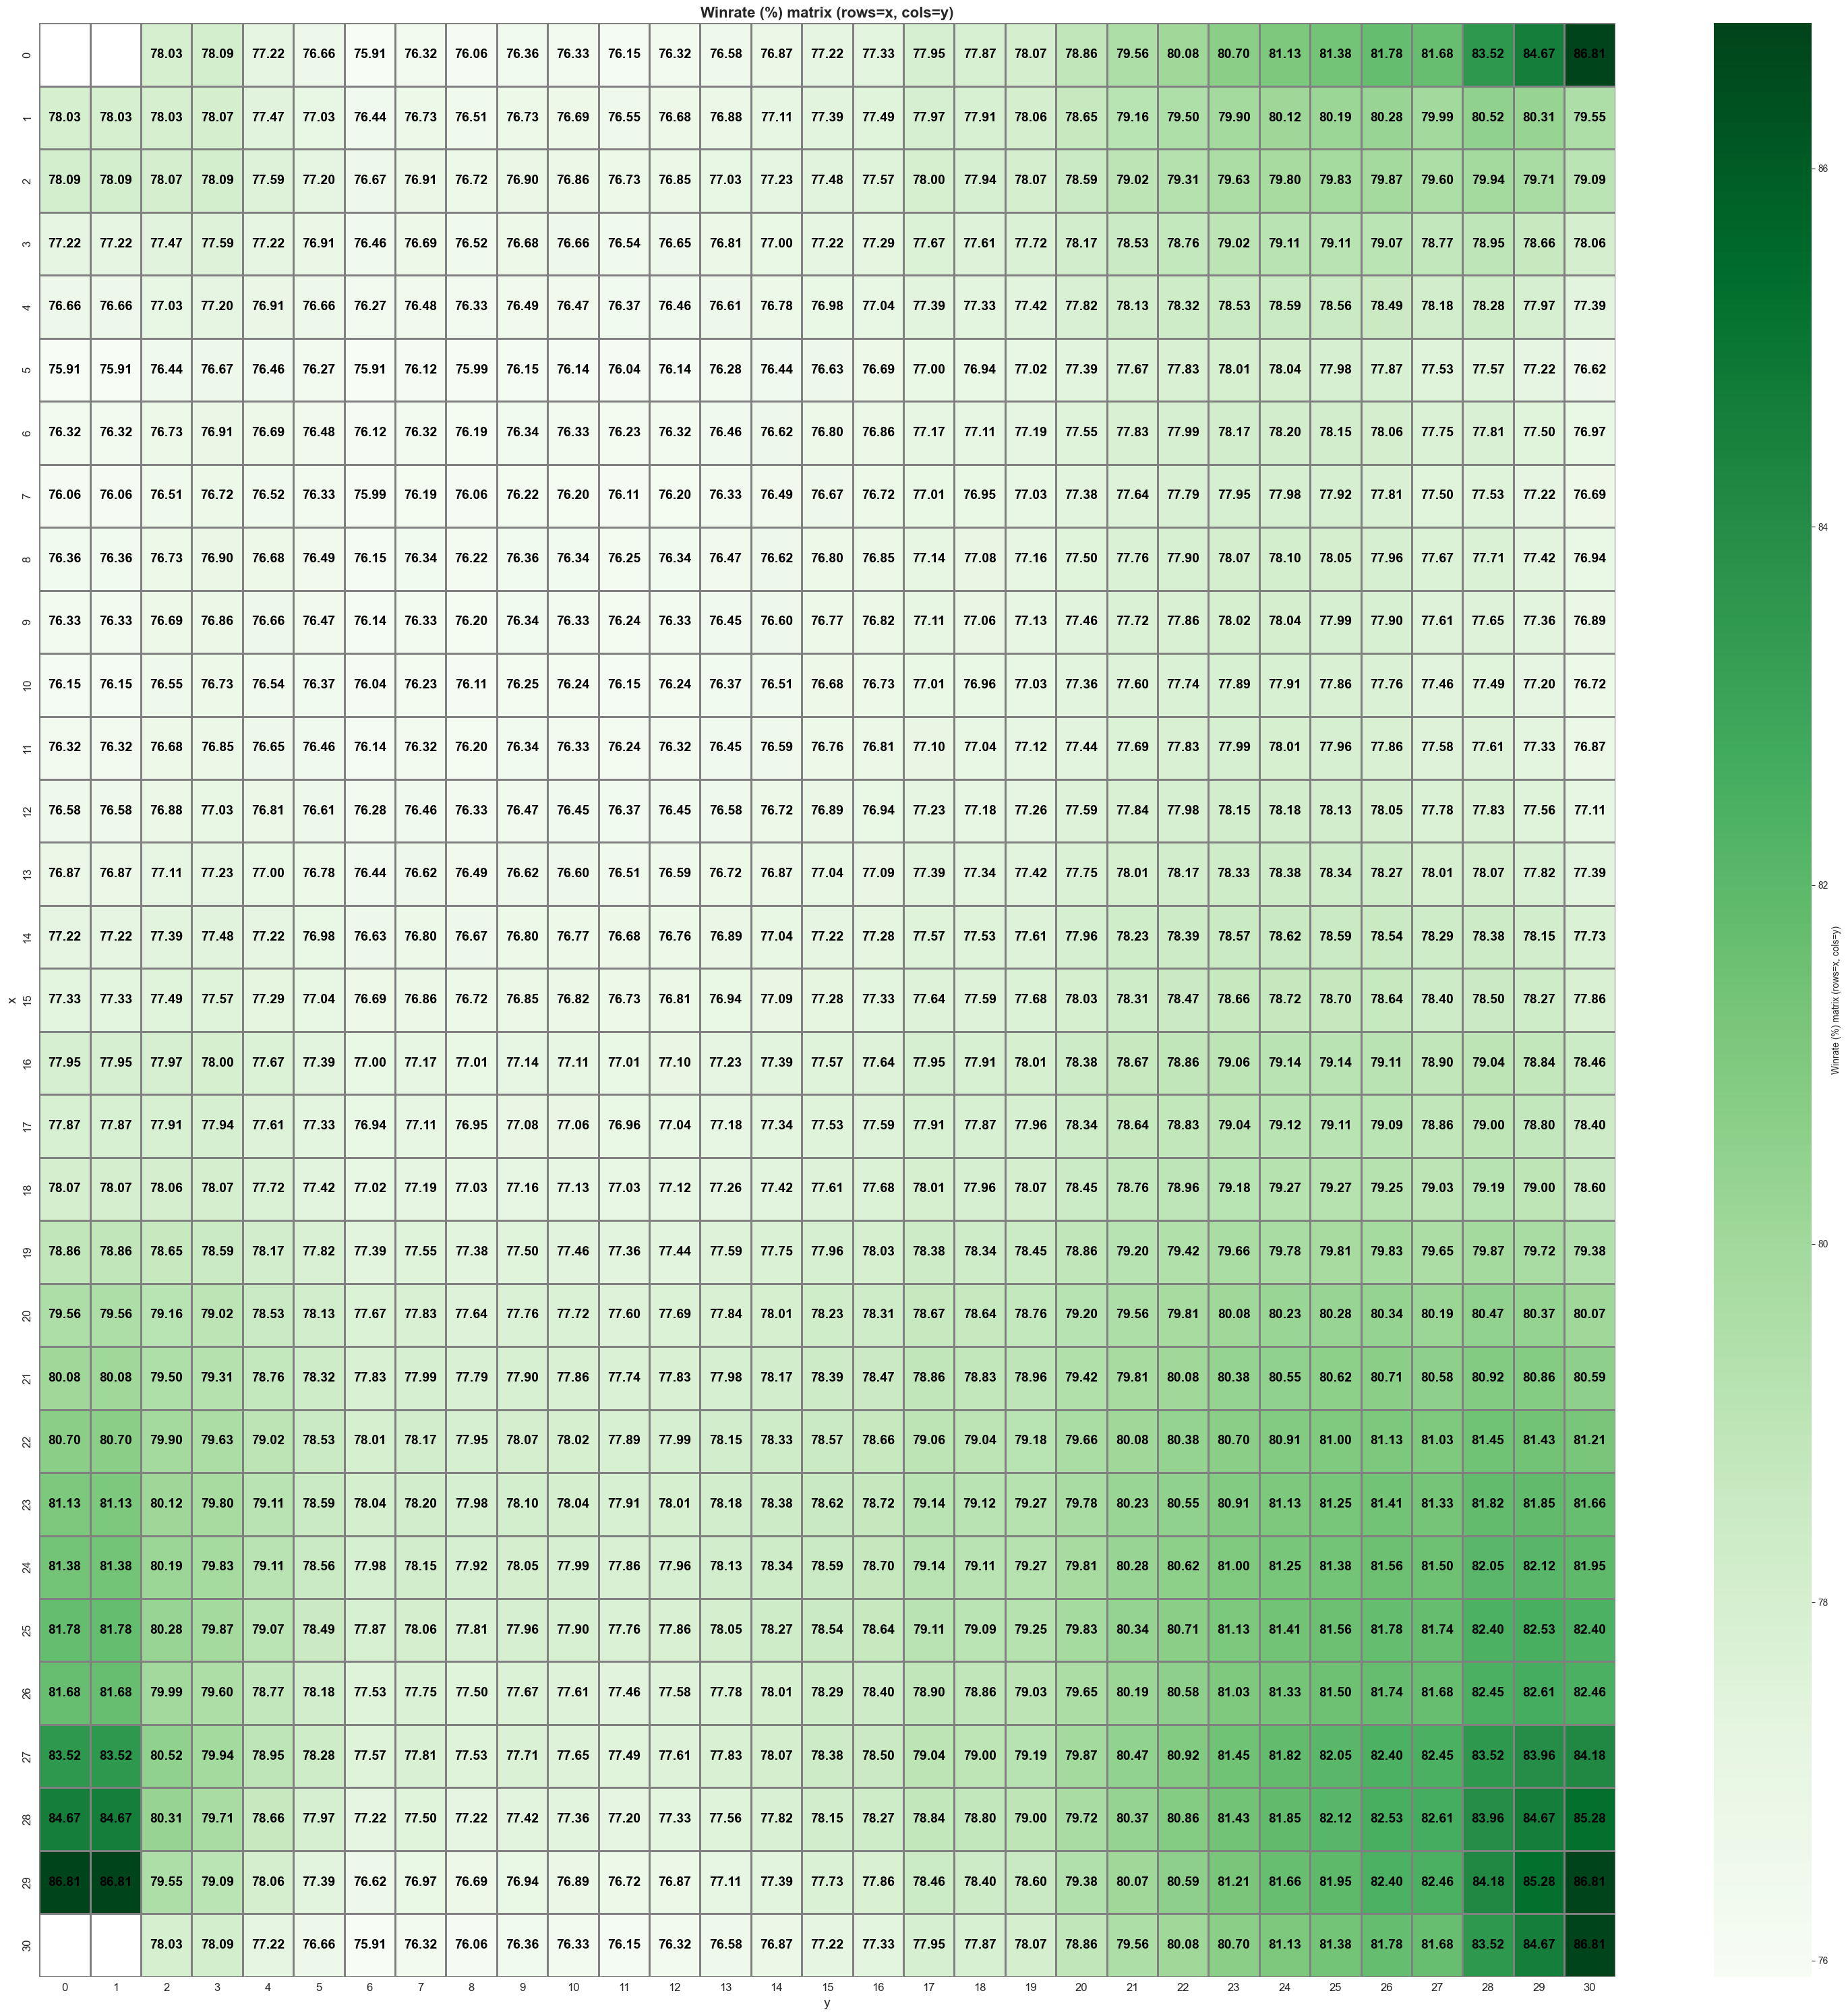

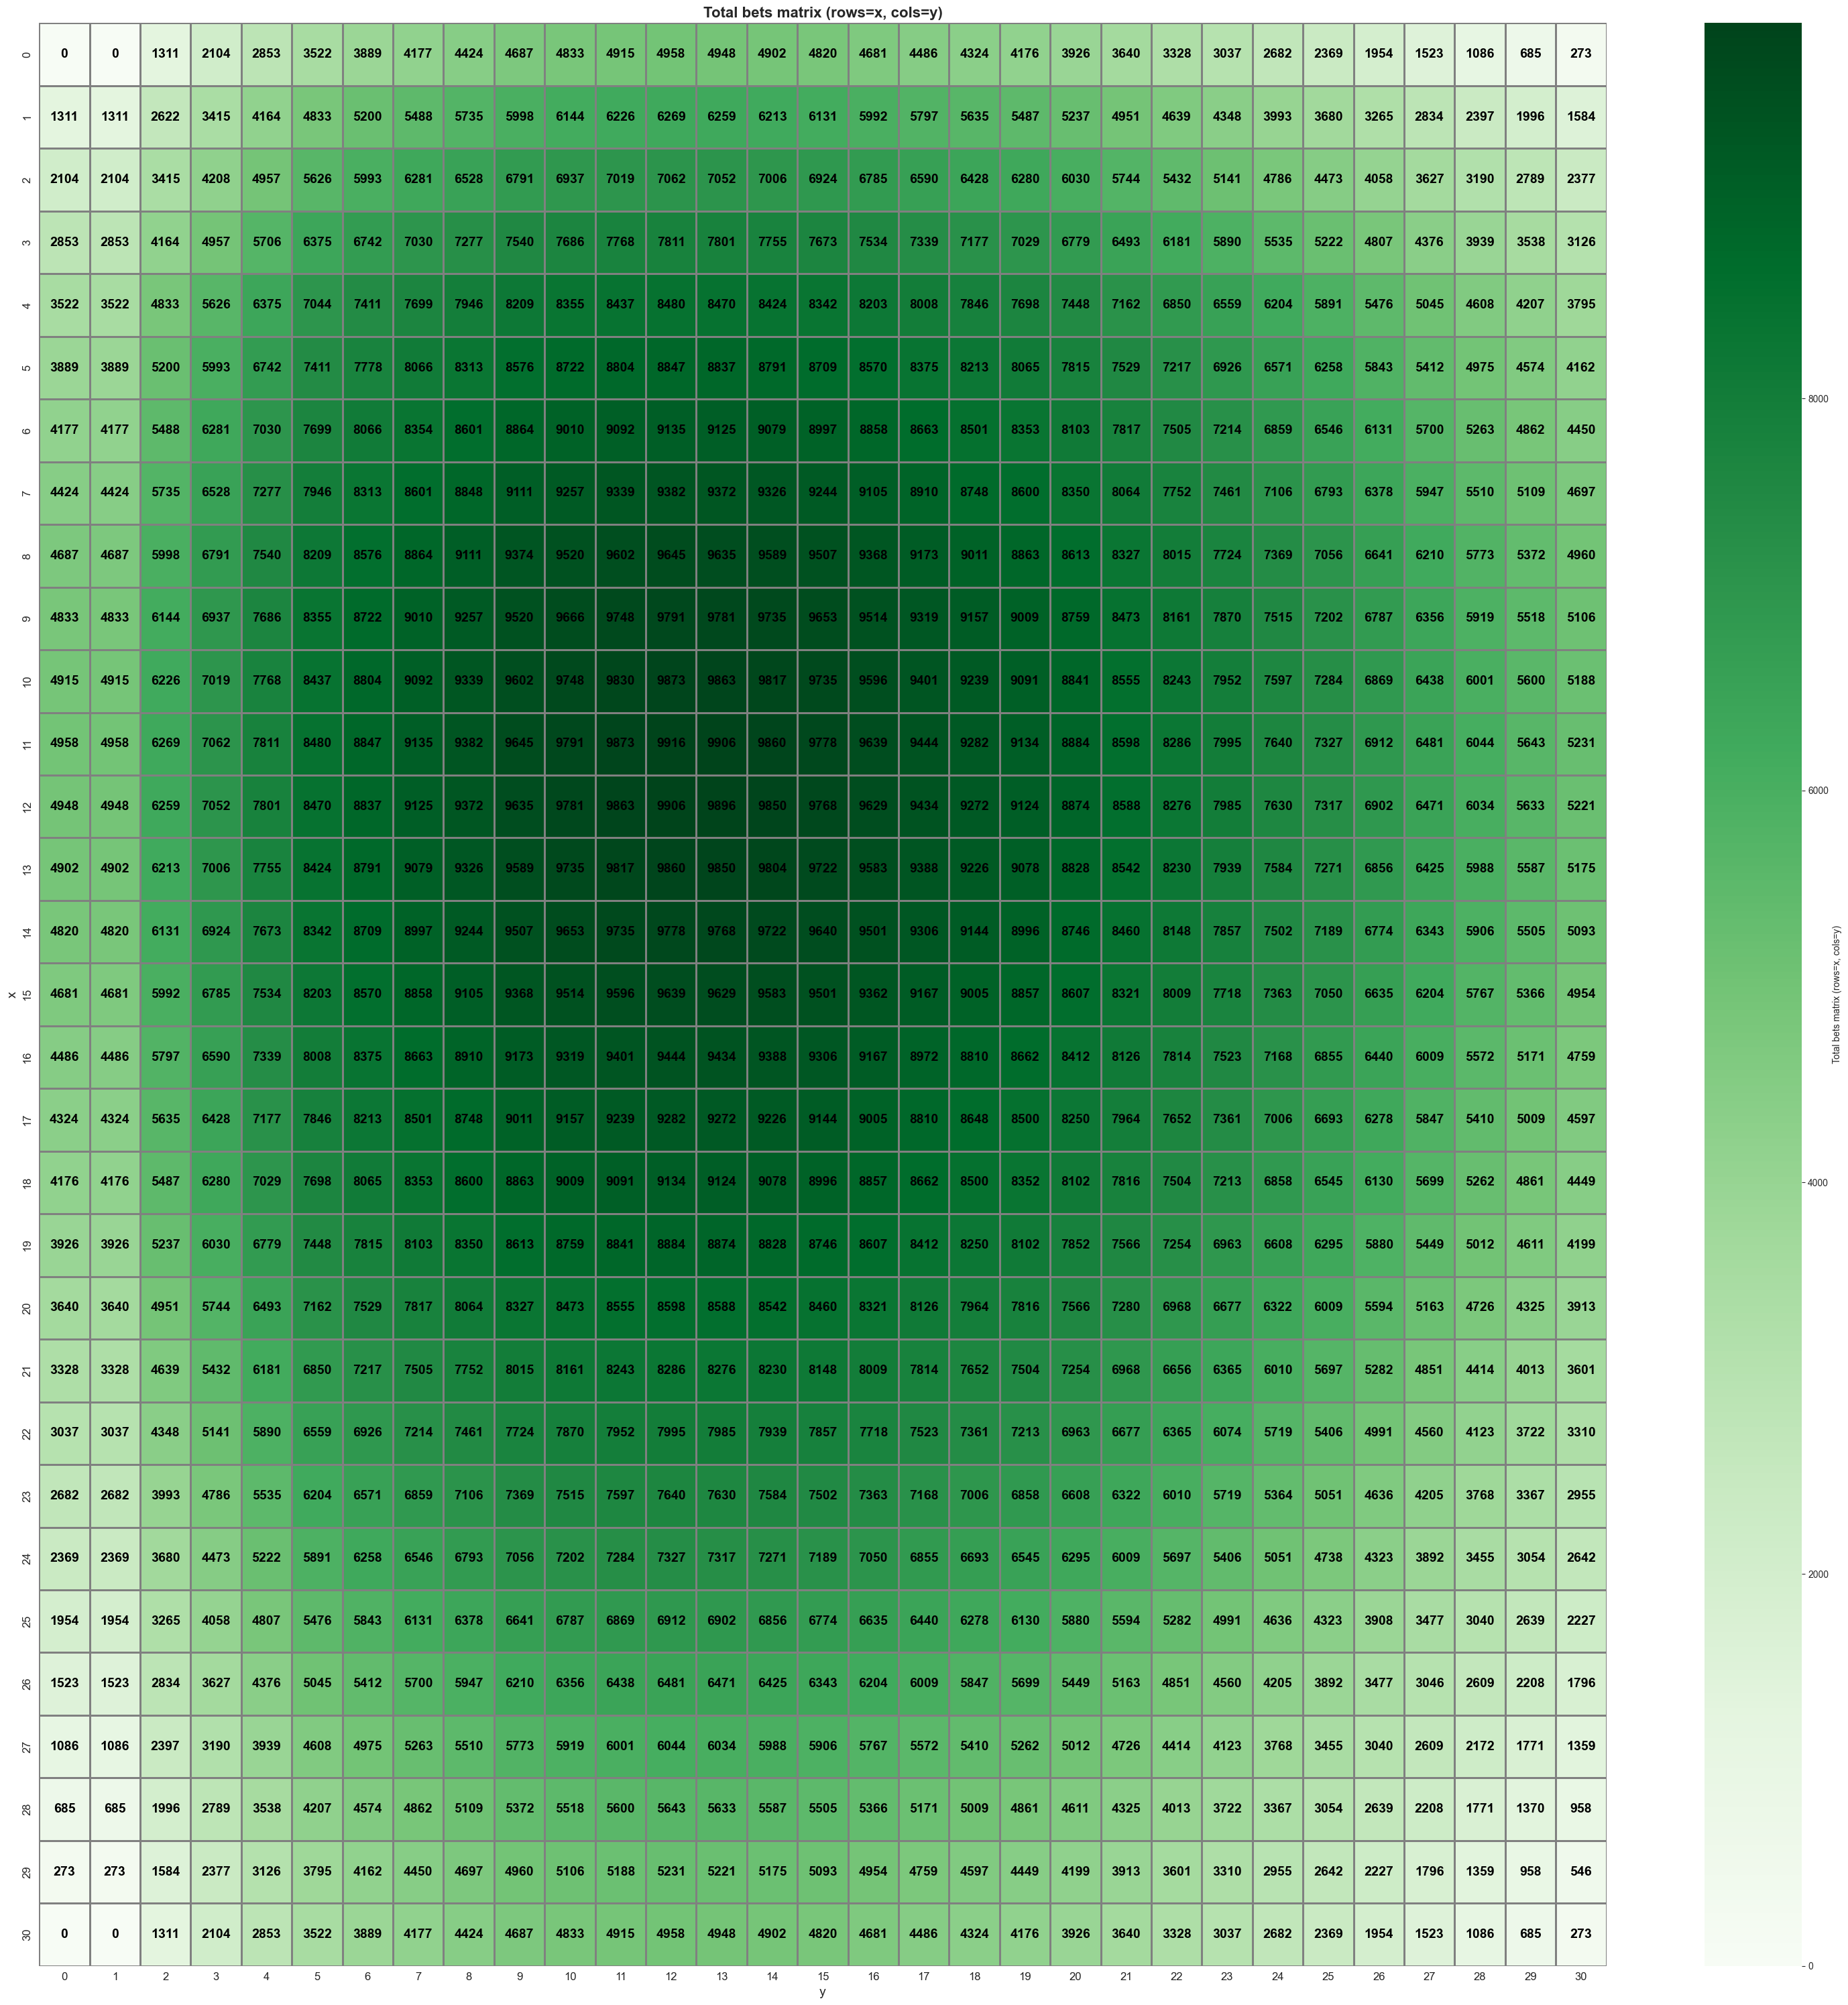

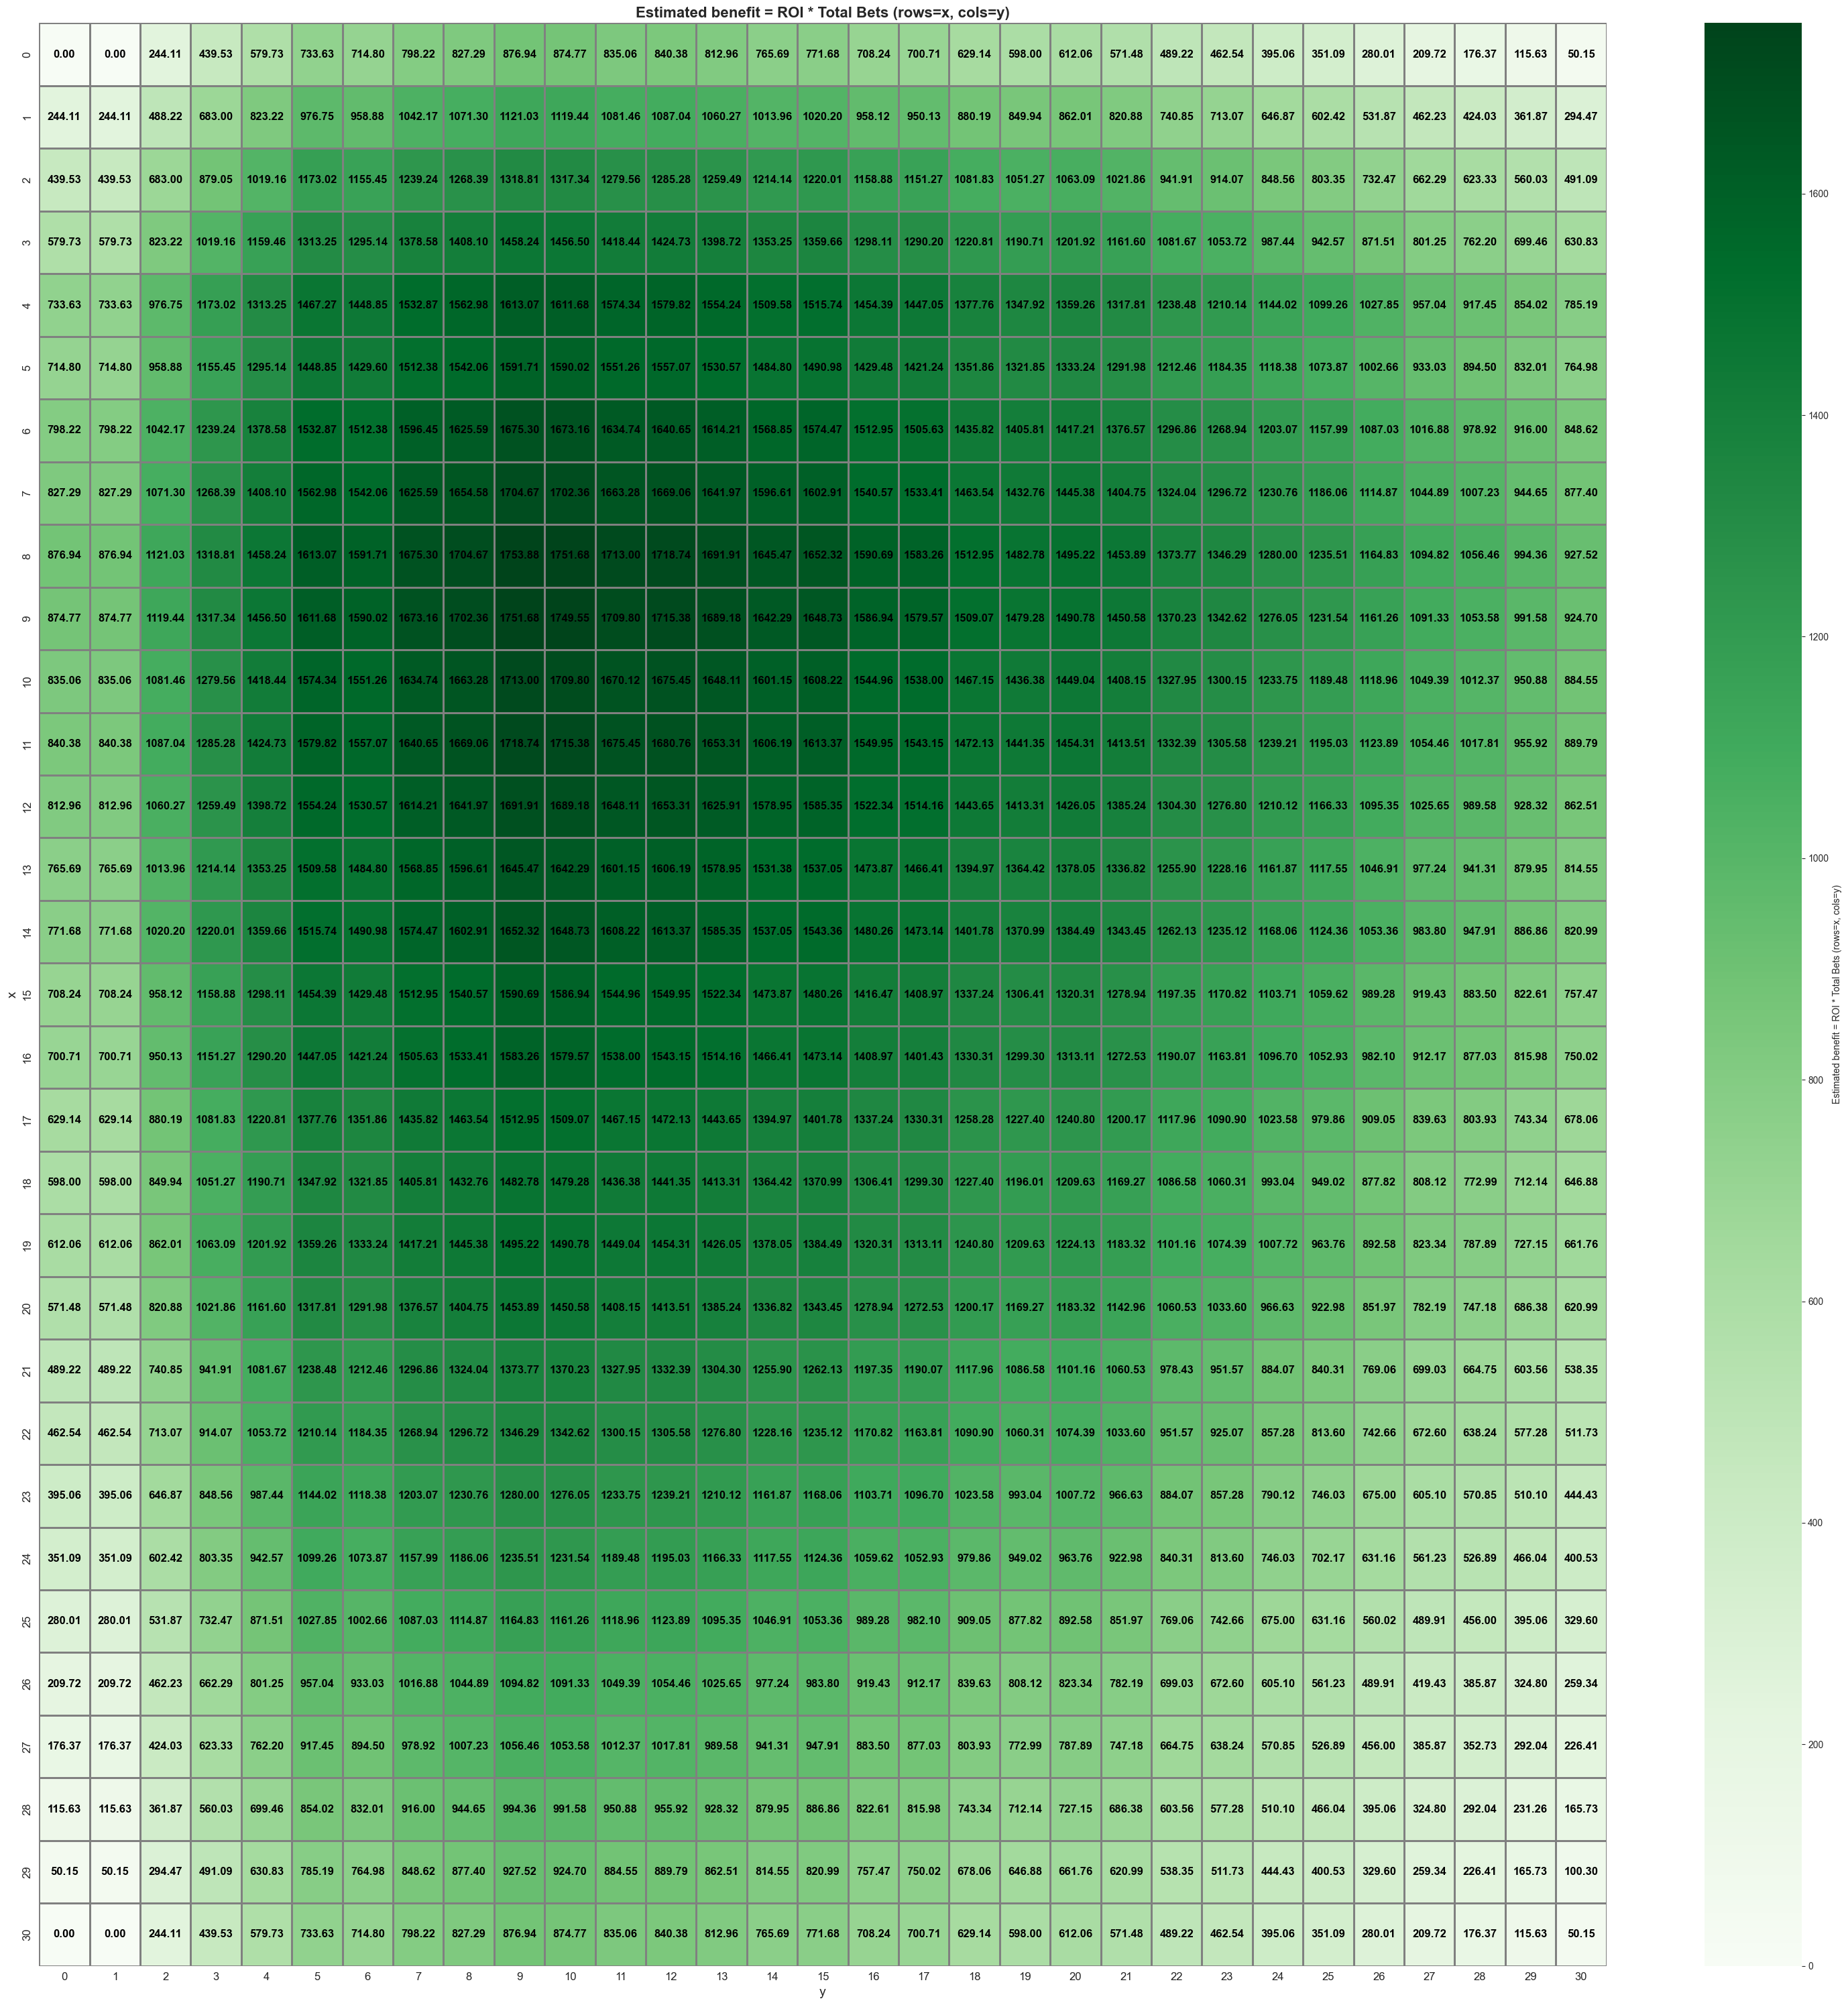

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap_matrix(mat, title, cmap='Greens', fmt=".2f",
                        figsize=(30, 30), annot_size=7, save_path=None, dpi=200):
    data = mat.astype(float)
    mask = data.isna()

    # vmin/vmax robustos
    finite_vals = data.values[~np.isnan(data.values)]
    if finite_vals.size == 0:
        vmin, vmax = 0, 1
    else:
        vmin, vmax = finite_vals.min(), finite_vals.max()
        if vmin == vmax:
            vmax = vmin + 1e-6

    plt.figure(figsize=figsize)
    sns.set_style("white")
    sns.heatmap(data,
                mask=mask,
                cmap=cmap,
                annot=True,
                fmt=fmt,
                vmin=vmin,
                vmax=vmax,
                annot_kws={'fontsize': annot_size, 'weight': 'bold', 'color': 'black'},
                linewidths=0.8,
                linecolor='gray',
                cbar_kws={'label': title},
                square=False)

    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('y', fontsize=14)
    plt.ylabel('x', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi)
    plt.show()

# ejemplos de llamada (ajusta figsize / annot_size si hace falta)
plot_heatmap_matrix(roi_matrix, "ROI matrix (rows=x, cols=y)", fmt=".3f",figsize=(30, 30), annot_size=16, save_path="roi_heatmap.png")
plot_heatmap_matrix(winrate_matrix, "Winrate (%) matrix (rows=x, cols=y)", fmt=".2f",figsize=(30, 30), annot_size=14, save_path="winrate_heatmap.png")
plot_heatmap_matrix(totalbets_matrix, "Total bets matrix (rows=x, cols=y)", fmt=".0f",figsize=(30, 30), annot_size=14, save_path="totalbets_heatmap.png")
roi_total_matrix = (roi_matrix.fillna(0).astype(float) * totalbets_matrix.fillna(0).astype(float))

# Guardar y mostrar por consola (opcional)
roi_total_matrix.to_csv("roi_total_matrix_x0_30_y0_30.csv")
plot_heatmap_matrix(roi_total_matrix,"Estimated benefit = ROI * Total Bets (rows=x, cols=y)",fmt=".2f",figsize=(30,30),annot_size=12,save_path="roi_total_heatmap.png")
# ...existing code...

In [15]:
# df_test = prepare_betting_analysis(merged, 3, 10, mode=-1)
df_test1 = prepare_betting_analysis(merged, 8, 10, mode=1)
df_test2 = prepare_betting_analysis(merged, 4, 10, mode=-1)
df_combined = pd.concat([df_test1, df_test2], ignore_index=True, sort=False)
df_test = df_combined.sort_values('date', ascending=True).reset_index(drop=True)

calcular_estadisticas(df_test.loc[df_test['result'] != -1])

C:\Users\andre\AppData\Local\Temp\ipykernel_368\3347867523.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profit'] = np.where(
C:\Users\andre\AppData\Local\Temp\ipykernel_368\3347867523.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['equity'] = df['profit'].cumsum()
C:\Users\andre\AppData\Local\Temp\ipykernel_368\3347867523.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

{'Total Bets': 9520,
 'ROI': 0.184,
 'Yield': 1.05,
 'Winrate': 76.34,
 'Total Profit': 9955.89,
 'Max Drawdown (%)': -24.22}

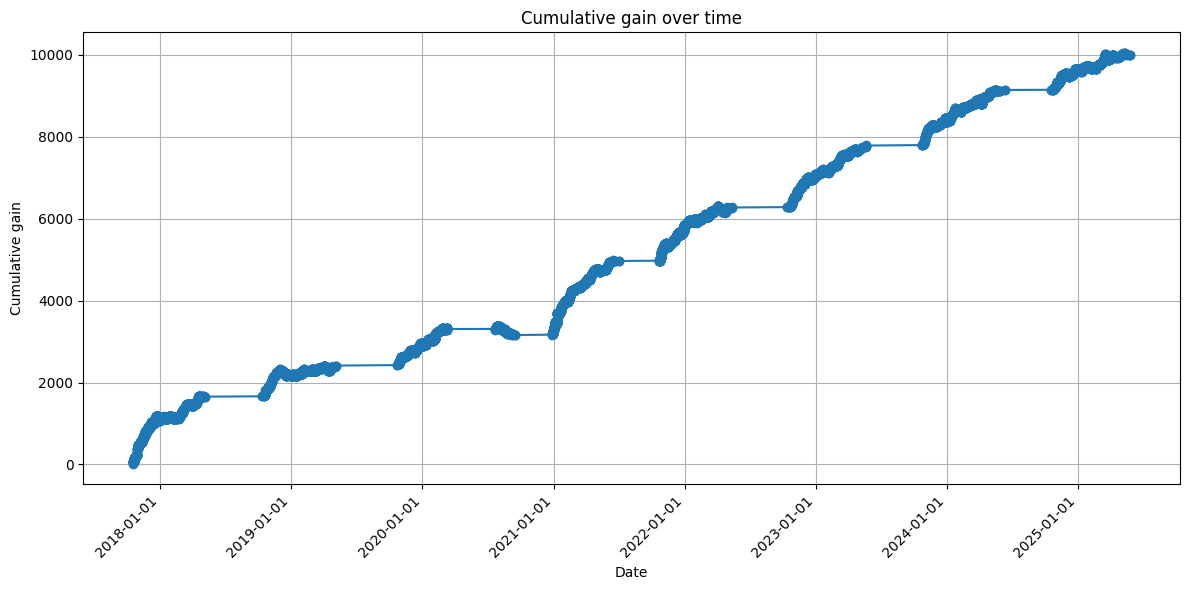

In [8]:
return_grafic(df_test.loc[df_test['result'] != -1])

In [78]:
df_test.loc[df_test["result"] == 0].tail(10)

GAME_ID   SEASON  HOME_TEAM_ID  AWAY_TEAM_ID  HOME_RANK  AWAY_RANK  \
10110  0042400202  2024-25  1.610613e+09  1.610613e+09        2.0        8.0   
10756  0042400232  2024-25  1.610613e+09  1.610613e+09       10.0        4.0   
10751  0042400223  2024-25  1.610613e+09  1.610613e+09        9.0        1.0   
10741  0042400214  2024-25  1.610613e+09  1.610613e+09        7.0        2.0   
10744  0042400205  2024-25  1.610613e+09  1.610613e+09        2.0        8.0   
10753  0042400235  2024-25  1.610613e+09  1.610613e+09        9.0        4.0   
10748  0042400226  2024-25  1.610613e+09  1.610613e+09        9.0        1.0   
10739  0042400216  2024-25  1.610613e+09  1.610613e+09        6.0        2.0   
10761  0042400313  2024-25  1.610613e+09  1.610613e+09        9.0        1.0   
10774  0042400401  2024-25  1.610613e+09  1.610613e+09        1.0        6.0   

       HOME_W  AWAY_W  HOME_Average_H  HOME_Average_A       HOME_GAME_DATE  \
10110       0       1            1.47            2.80  2025-05-06 00:00:00   
10756       1       0            1.20            5.00  2025-05-08 00:00:00   
10751       1       0            2.85            1.42  2025-05-09 00:00:00   
10741       1       0            3.05            1.41  2025-05-12 00:00:00   
10744       0       1            1.29            3.85  2025-05-13 00:00:00   
10753       1       0            1.23            4.40  2025-05-14 00:00:00   
10748       1       0            2.55            1.50  2025-05-15 00:00:00   
10739       1       0            1.72            2.15  2025-05-16 00:00:00   
10761       1       0            2.30            1.66  2025-05-24 00:00:00   
10774       0       1            1.21            4.70  2025-06-05 00:00:00   

       HOME_GAMES_PLAYED  AWAY_GAMES_PLAYED  PREDICTION  result  odds  stake  \
10110               47.0               47.0           1       0  1.47   1.47   
10756               47.0               50.0           0       0  5.00   5.00   
10751               49.0               45.0           0       0  1.42   1.42   
10741               49.0               47.0           0       0  1.41   1.41   
10744               48.0               48.0           1       0  1.29   1.29   
10753               48.0               51.0           0       0  4.40   4.40   
10748               51.0               47.0           0       0  1.50   1.50   
10739               50.0               48.0           0       0  2.15   2.15   
10761               49.0               48.0           0       0  1.66   1.66   
10774               54.0               52.0           1       0  1.21   1.21   

                      date  
10110  2025-05-06 00:00:00  
10756  2025-05-08 00:00:00  
10751  2025-05-09 00:00:00  
10741  2025-05-12 00:00:00  
10744  2025-05-13 00:00:00  
10753  2025-05-14 00:00:00  
10748  2025-05-15 00:00:00  
10739  2025-05-16 00:00:00  
10761  2025-05-24 00:00:00  
10774  2025-06-05 00:00:00